In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%matplotlib inline

In [3]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

import numpy as np
#import scipy

import darkhistory.physics as phys
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import scipy.special

# import main as main

from tqdm import tqdm_notebook as tqdm

import pickle
import config
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
import string

# Excitation

In [4]:
#~~~ BOUND_BOUND FUNCTIONS~~~

ZEROTEMP  = 1e-10   #/* (in eV) Treat temperatures below that threshold as being exactly zero */

#*************************************************# 
#A_{nl} coefficient defined in Hey (2006), Eq. (9)# 
#*************************************************#

def Hey_A(n, l):
    return np.sqrt(n**2-l**2)/(n*l)

#/*****************************************************************# 
#Absolute value of R_{n', n'- 1}^{n n'} as in Hey (2006), Eq. (B.4) 
#Assumes n > np.
#******************************************************************#

lgamma = scipy.special.loggamma
def Hey_R_initial(n, n_p):
#     return (-1)**(n-n_p-1) * 2**(2*n_p+2) * np.sqrt(
#         fact(n+n_p)/fact(n-n_p-1)/fact(2*n_p-1)) * (
#         n_p/n)**(n_p+2) * (1-n_p/n)**(n-n_p-2)/(1+n_p/n)**(n+n_p+2)
    return np.exp(
        (2.0*n_p + 2.0) * np.log(2.0) + 
        0.5 * (lgamma(n+n_p+1) - lgamma(n-n_p) - lgamma(2.0*n_p)) 
        + (n_p + 2.0) * np.log(n_p/n) 
        + (n-n_p - 2.0) * np.log(1.0 - n_p/n) - (n + n_p + 2.0) * np.log(1.0 + n_p/n)
    )

#/*********************************************************************
#Populates a matrix with the radial matrix elements.
#Inputs: two [nmax+1][nmax+1][nmax] matrices Rup, Rdn, nmax.
#Rup is populated s.t. R_up[n][n'][l] = R([n,l],[n',l+1])
#Rdn is populated s.t. R_dn[n][n'][l] = R([n,l],[n',l-1])
#Assumption: n > n'
#**********************************************************************/

def populate_radial(nmax):
    R_up = np.zeros((nmax+1,nmax,nmax))
    R_dn = np.zeros((nmax+1,nmax,nmax))
        
    for n in np.arange(2,nmax+1,1):
        for n_p in np.arange(1,n):
            #/* Initial conditions: Hey (2006) Eq. (B.4). */
            R_dn[n][n_p][n_p] = Hey_R_initial(n, n_p)
            R_up[n][n_p][n_p-1] = R_up[n][n_p][n_p] = 0
            for l in np.arange(n_p-1,0,-1):
                #/* Hey (52-53) */
                R_dn[n][n_p][l] = ((2*l+1) * Hey_A(n, l+1) * R_dn[n][n_p][l+1] 
                    + Hey_A(n_p, l+1) * R_up[n][n_p][l]) / (2.0 * l * Hey_A(n_p, l))
         
                R_up[n][n_p][l-1] = ((2*l+1) * Hey_A(n_p, l + 1) * R_up[n][n_p][l] 
                    + Hey_A(n, l+1) * R_dn[n][n_p][l+1]) / (2.0 * l * Hey_A(n, l))
    
    return {'up': R_up, 'dn': R_dn}

# /*************************************************************************************************************** 
# Populates two matrices with the bound-bound rates for emission and absorption, 
#  in a black-body radiation field.
# Inputs : two [nmax+1][nmax+1][nmax] matrices BB_up and BB_dn, nmax, Tr (IN EV !), 
#  and the two precomputed matrices of radial matrix elements R_up and R_dn.
# BB_up[n][n'][l] = A([n,l]-> [n',l+1]) * (1 + f(E_{nn'}))                if n > n'
#                 = (2l+3)/(2l+1) exp(-E_{nn'}/Tr) * BB_dn[n'][n][l+1]    if n < n'
# BB_dn[n][n'][l] = A([n,l]-> [n',l-1]) * (1 + f(E_{nn'}))                if n > n'      
#                 = (2l-1)/(2l+1) exp(-E_{nn'}/Tr) * BB_up[n'][n][l-1]    if n < n'             
#  *****************************************************************************************************************/

hplanck = phys.hbar*2*np.pi
def populate_bound_bound(nmax, Tr, R): 
    BB = {key: np.zeros((nmax+1,nmax+1,nmax)) for key in ['up', 'dn']}
    for n in np.arange(2,nmax+1,1):
        n2 = n**2
        for n_p in np.arange(1,n,1):
            n_p2 = n_p**2
            Ennp = (1/n_p2 - 1/n2) * phys.rydberg; 
            if (Tr < ZEROTEMP):    #/* if Tr = 0*/
                fEnnp = 0.0;
            else:
                fEnnp = np.exp(-Ennp/Tr)/(1-np.exp(-Ennp/Tr))
                #fEnnp = 1/(np.exp(Ennp/Tr)-1) 

            common_factor = 2*np.pi/3 * phys.rydberg / hplanck * (
                phys.alpha * (1/n_p2 - 1/n2))**3
            
            for l in np.arange(0,n_p+1,1): #/* Spont + stim emission */
                A_up = common_factor * (l+1) / (2*l+1) * R['up'][n][n_p][l]**2
                A_dn = common_factor *   l   / (2*l+1) * R['dn'][n][n_p][l]**2
                BB['up'][n][n_p][l] = A_up * (1+fEnnp)
                BB['dn'][n][n_p][l] = A_dn * (1+fEnnp)
                         
            BB['up'][n][n_p][n_p] = BB['up'][n][n_p][n_p-1] = 0.0   #/* No l' >= n' */
            BB['dn'][n][n_p][0]   = 0.0                          #/* No l' < 0   */
            for l in np.arange(0,n_p,1): #/* Absorption obtained by detailed balance */       
                if (Tr < ZEROTEMP):  #/* if Tr = 0 */
                    BB['up'][n_p][n][l] = BB['dn'][n_p][n][l+1] = 0.0;
                else:
                    BB['up'][n_p][n][l]   = (2*l+3)/(2*l+1) * np.exp(-Ennp/Tr) * BB['dn'][n][n_p][l+1]
                    BB['dn'][n_p][n][l+1] = (2*l+1)/(2*l+3) * np.exp(-Ennp/Tr) * BB['up'][n][n_p][l]
    
    return BB

# /********************** HL FUNCTION *******************************************************************************
# Populates two matrices with the bound-bound rates for emission and absorption, in an arbitrary radiation field.
# Note that Tr parametrizes the redshift: we assume that the spectrum is almost a blackbody with temperature Tr.
# Inputs : two [nmax+1][nmax+1][nmax] matrices BB_up and BB_dn, nmax, a photon_dist structure, 
#  *****************************************************************************************************************/

# void populate_bound_bound_nonBB(
#     double ***BB_up, double ***BB_dn, unsigned nmax, double Tr, photon_dist *dist, double ***R_up, double ***R_dn
# ){
#     /* If it is a blackbody, call the old function. */
#     if (dist->blackbody){
#         populate_bound_bound(BB_up, BB_dn, nmax, Tr, R_up, R_dn);
#     }
#     else{
#         unsigned l, n, np; 
#         double n2, np2, Ennp, rs, fEnnp, common_factor, A_up, A_dn; 
#         for (n = 2; n <= nmax; n++){
#             n2 = ((double) n) * ((double) n);
#             for (np = 1; np < n; np++){
#                 np2 = ((double) np) * ((double) np); 
#                 Ennp = (1.0 / np2 - 1.0 / n2) * EI;
#                 /* Calculate redshift, obtain the photon occupancy */
#                 rs = Tr/Tr0;
#                 fEnnp = dist->f_occup(Ennp, rs);
#                 common_factor = 2.0 * np.pi/3.0 * EI / hPlanck * pow(alpha_fs *(1.0 / np2 - 1.0 / n2), 3.0);
#                 for (l = 0; l <= np; l++){
#                     /* Spont + stim emission */
#                     A_up = common_factor * (l + 1.0) / (2.0 * l + 1.0) * R_up[n][np][l] * R_up[n][np][l];
#                     A_dn = common_factor *     l     / (2.0 * l + 1.0) * R_dn[n][np][l] * R_dn[n][np][l];
#                     BB_up[n][np][l] = A_up * (1.0 + fEnnp);
#                     BB_dn[n][np][l] = A_dn * (1.0 + fEnnp);
#                 BB_up[n][np][np] = BB_up[n][np][np-1] = 0.0;   /* No l' >= n' */
#                 BB_dn[n][np][0] = 0.0;                         /* No l' < 0   */
#                 for (l = 0; l < np; l++){
#                     #/* Replaced Boltzmann weight by f/(1+f) */   
#                     BB_up[np][n][l]   = (2.0 * l + 3.0) / (2.0 * l + 1.0) * (fEnnp / (1.0 + fEnnp)) * BB_dn[n][np][l+1];
#                     BB_dn[np][n][l+1] = (2.0 * l + 1.0) / (2.0 * l + 3.0) * (fEnnp / (1.0 + fEnnp)) * BB_up[n][np][l];


In [74]:
#~~~ BOUND_FREE FUNCTIONS ~~~

EI       = 13.5982860719383 #/*13.60569193 / (1.0 + me_mp)*/       /* Ionization energy of hydrogen in eV, accounting for reduced mass */
alpha_fs = 7.2973525376e-3                                                     #/* Fine structure constant */
hPlanck  = 4.13566733e-15                                                      #/* Planck's constant in eV*s */
cLight   = 2.99792458e10                                                       #/* Speed of light in cm/s */
mue      = 510720.762779219              #/*me / (1.0 + me_mp)*/               #/* Reduced mass of hydrogen in eV*/ 

# /*********************************************************************************************************************
# Populates two matrices with the coefficients g(n, l; kappa, l+1) and g(n, l; kappa, l-1).
# Input: two [nmax] matrices g_up and g_dn, n, kappa.
# The matrices are populated s.t. g_up[l] = g(n, l; kappa, l+1) 
#                                 g_dn[l] = g(n, l; kappa, l-1).
# Reference: Burgess A.,1965, MmRAS..69....1B, Eqs. (28)-(34). 
# **********************************************************************************************************************/

def populate_gnlk(nmax, n, kappa):
    gnk_up = np.zeros(nmax)
    gnk_dn = np.zeros(nmax)
    
    k2 = kappa**2
    n2 = n**2
        
    log_product = 0.0;
    
    for s in range(1, n+1):
        log_product = log_product + np.log(1.0 + s*s*k2)
    log_init = (0.5 * (np.log(np.pi/2) - lgamma(2.0 * n)) + np.log(4.0) + n * np.log(4.0 * n) + 0.5 * log_product
             - 0.5 * np.log(1.0 - np.exp(-2.0 * np.pi / kappa)) - 2.0 * np.arctan(n * kappa) / kappa 
             - (n + 2.0) * np.log(1.0 + n2 * k2))
    gnk_up[n-1] = np.exp(log_init)
    gnk_dn[n-1] = 0.5 * np.sqrt((1.0 + n2 * k2) / (1.0 + (n - 1.0) * (n - 1.0) * k2)) / n * gnk_up[n-1]
 
    if n > 1:
        gnk_up[n-2] = 0.5 * np.sqrt((2.0 * n - 1.0) * (1.0 + n2 * k2)) * gnk_up[n-1]    
        gnk_dn[n-2] = 0.5 * (4.0 + (n - 1.0) * (1.0 + n2 * k2)) * np.sqrt(
            (2.0 * n - 1.0) / (1.0 + (n - 2.0) * (n - 2.0) * k2)) / n * gnk_dn[n-1]  
        for l in range(n-1,1,-1): 
            l2 = l**2
            gnk_up[l-2] = 0.5 * (((4.0 * (n2 - l2) + l * (2.0 * l - 1.0) * (1.0 + n2 * k2)) * gnk_up[l-1]
                              - 2.0 * n * np.sqrt((n2 - l2) * (1.0 + (l + 1.0) * (l + 1.0) * k2)) * gnk_up[l])
                                / np.sqrt((n2 - (l - 1.0) * (l - 1.0)) * (1.0 + l2 * k2)) / n)
        
        for l in range(n-2,0,-1):  
            l2 = l**2;
            gnk_dn[l-1] = 0.5 * (((4.0 * (n2 - l2) + l * (2.0 * l + 1.0) * (1.0 + n2 * k2)) * gnk_dn[l]
                              - 2.0 * n * np.sqrt((n2 - (l + 1.0) * (l + 1.0)) * (1.0 + l2 * k2)) * gnk_dn[l+1])
                              / np.sqrt((n2 - l2) * (1.0 + (l - 1.0) * (l - 1.0) * k2)) / n)
    return gnk_up, gnk_dn


# /************************************************************************************************************************
# Populates one array n2k2[Nkappa] and two [nmax+1][Nkappa][nmax] matrices g_up, g_dn, s.t.
# - Nkappa = 10 * NBINS + 1
# - n2k2 has NBINS logarithmically spaced bins between n2k2min and n2k2max, each bin containing 11 linearly spaced values
# for later 11-point Newton-Cotes integration (as in Grin & Hirata, 2010).
# - g_up[n][ik][l] = g(n, l; kappa[ik], l+1)
# - g_dn[n][ik][l] = g(n, l; kappa[ik], l-1)
# *************************************************************************************************************************/

def populate_n2k2_and_g_old(nmax):
    n2k2 = np.zeros(10 * (NBINS-1) + 11)
    g = {key: np.zeros((nmax+1,Nkappa,nmax)) for key in ['up', 'dn']}
    
    n2k2min = 1e-25                             #/* Min value of n^2 kappa^2 table */
    n2k2max = 4.96e8                            #/* Max value of n^2 kappa^2 table */

    bigBins = np.zeros(NBINS + 1)
    temp = np.zeros(11)

    #/* Populating n2k2: Nbins logarithmically spaced bins, each has 10 sub-bins */
    bigBins = np.logspace(np.log10(n2k2min), np.log10(n2k2max), NBINS + 1)
    
    for iBig in range(NBINS):
        temp = np.linspace(bigBins[iBig], bigBins[iBig+1], 11)
        for i in range(11):
            n2k2[10 * iBig + i] = temp[i];
    
    #/* Now populating the g's */
    for n in range(1, nmax+1):
        for ik in range(10*NBINS + 1):
            g['up'][n][ik], g['dn'][n][ik] = populate_gnlk(nmax, n, np.sqrt(n2k2[ik]) / n)
            
    return n2k2, g


# /********************************************************************************************
# k2[n][ik] because boundaries depend on n
#  ********************************************************************************************/

def populate_k2_and_g(nmax, TM):
    k2_tab = np.zeros((nmax+1,10 * (NBINS-1) + 11))
    g = {key: np.zeros((nmax+1,Nkappa,nmax)) for key in ['up', 'dn']}
    k2max = 7e2*TM/EI        

    for n in range(1,nmax+1):
        k2min = 1e-25/n/n
        bigBins = np.logspace(np.log10(k2min), np.log10(k2max), NBINS + 1)
        for iBig in range(NBINS):
            temp = np.linspace(bigBins[iBig], bigBins[iBig+1], 11)
            for i in range(11):
                k2_tab[n][10 * iBig + i] = temp[i]
        for ik in range(10 * NBINS + 1):
            g['up'][n][ik], g['dn'][n][ik] = populate_gnlk(nmax, n, np.sqrt(k2_tab[n][ik]))  
    return k2_tab, g


# /******************************************************************************************* 
# 11 point Newton-Cotes integration.
# Inputs: an 11-point array x, an 11-point array f(x).
# Output: \int f(x) dx over the interval provided.
# ********************************************************************************************/

def Newton_Cotes_11pt(x, f):
    h = (x[10] - x[0])/10.0 #/* step size */

    return (5.0 * h * (16067.0 * (f[0] + f[10]) + 106300.0 * (f[1] + f[9]) 
                      - 48525.0 * (f[2] + f[8]) + 272400.0 * (f[3] + f[7])
                      - 260550.0 * (f[4] + f[6]) + 427368.0 * f[5]) / 299376.0)

# /********************************************************************************************* 
# Populating the photoionization rates beta(n, l, Tr)
# Input: beta[nmax+1][nmax], Tr in eV, nmax
# and the precomputed tables n2k2, g_up[nmax+1][Nkappa][nmax], g_dn[nmax+1][Nkappa][nmax], 
# where Nkappa = 10 * NBINS + 1
# *********************************************************************************************/

# void populate_beta_old(double **beta, double Tr, unsigned nmax,
#                    double n2k2[], double ***g_up, double ***g_dn)
# {

#     unsigned n, l, iBin, i, ik;
#     double k2[11];
#     double int_b[11];
#     double n2;
#     double common_factor =  2.0/3.0 * alpha_fs * alpha_fs * alpha_fs * EI/hPlanck;

#     for (n = 1; n <= nmax; n++)
#     {
#         n2 = ((double) n) * ((double) n);
#         for (l = 0; l < n; l++)
#         {
#            beta[n][l] = 0.0;
#            for (iBin = 0; iBin < NBINS; iBin++)
#            {
#               for (i = 0; i < 11; i++)
#               {
#                   ik = 10 * iBin + i;
#                   k2[i] = n2k2[ik] / n2;
#                   if (Tr < 1e-10)      /* Flag meaning TR = 0 */
#                   {
#                       int_b[i] = 0.0;
#                   }
#                   else
#                   {
#                       int_b[i] = pow(1.0 + n2k2[ik], 3.0) / (exp(EI / Tr * (k2[i] + 1.0 / n2)) - 1.0) * 
#                               ((l + 1.0) * g_up[n][ik][l] * g_up[n][ik][l] + l * g_dn[n][ik][l] * g_dn[n][ik][l]);  
#                   }           
#               }
#               beta[n][l] +=  Newton_Cotes_11pt(k2, int_b);
#            }
#            beta[n][l]  *= common_factor / n2 / (2.0 * l + 1.0); 
#         }
#     } 
# }

# /*******************************************************************************/

def populate_beta(TM, Tr, nmax, k2_tab, g):
    k2 = np.zeros(11)
    int_b = np.zeros(11)
    common_factor =  2.0/3.0 * alpha_fs**3 * EI/hPlanck
    beta = np.zeros((nmax+1,nmax))

    for n in range(1, nmax+1):
        n2 = n**2
        for l in range(n):
            for iBin in range(NBINS):
                for i in range(11):
                    ik = 10 * iBin + i
                    k2[i] = k2_tab[n][ik]
                    if (Tr < 1e-10):      #/* Flag meaning TR = 0 */
                        int_b[i] = 0.0
                    else:
                        int_b[i] = ((1.0 + k2[i]*n2)**3 / (np.exp(EI / Tr * (k2[i] + 1.0 / n2)) - 1.0) * 
                                      ((l + 1.0) * g['up'][n][ik][l] * g['up'][n][ik][l] 
                                       + l * g['dn'][n][ik][l] * g['dn'][n][ik][l]))
                beta[n][l] +=  Newton_Cotes_11pt(k2, int_b)
            beta[n][l]  *= common_factor / n2 / (2.0 * l + 1.0)
    return beta

# /********************************************************************************************* 
# Populating the recombination coefficients alpha(n, l, Tm, Tr) 
# Input: alpha[nmax+1][nmax], Tm, Tr in eV, nmax
# and the precomputed tables n2k2, g_up[nmax+1][Nkappa][nmax], g_dn[nmax+1][Nkappa][nmax], 
# where Nkappa = 10 * NBINS + 1
# *********************************************************************************************/


# /****************************************************************************************/

def populate_alpha(Tm, Tr, nmax, k2_tab, g):
    k2 = np.zeros(11)
    int_a = np.zeros(11)   
    common_factor = (2.0/3.0 * alpha_fs**3 * EI/hPlanck 
                     * (hPlanck * hPlanck * cLight * cLight/(2.0 * np.pi * mue * Tm))**1.5)
    alpha = np.zeros((nmax+1,nmax))
    
    for n in range(1,nmax+1):
        n2 = n**2
        for l in range(n):
            for iBin in range(NBINS):
                for i in range(11):
                    ik = 10 * iBin + i
                    k2[i] = k2_tab[n][ik]
                    int_a[i] = ((1.0 + n2 *k2[i])**3 * np.exp(-k2[i] * EI / Tm) *
                                 ((l + 1.0) * g['up'][n][ik][l] * g['up'][n][ik][l] 
                                  + l * g['dn'][n][ik][l] * g['dn'][n][ik][l]))
                    if Tr > 1e-10:
                        int_a[i] /= (1. - np.exp(-EI/Tr*(k2[i] + 1./n2)))
                alpha[n][l] += Newton_Cotes_11pt(k2, int_a)
            alpha[n][l] *= common_factor / n2
    return alpha

# /********************** HL FUNCTION ***************************
#  Populating the photoionization rates beta(n, l, Tr)
#  Input: beta[nmax+1][nmax], Tr in eV, nmax
#  and the precomputed tables n2k2, g_up[nmax+1][Nkappa][nmax], g_dn[nmax+1][Nkappa][nmax], 
#  where Nkappa = 10 * NBINS + 1
# **************************************************************/
# void populate_beta_nonBB(double **beta, double Tr, photon_dist *dist,
#   unsigned nmax, double n2k2[], double ***g_up, double ***g_dn)
# {

#     /*If it is a blackbody, call the old function*/
#     if (dist->blackbody){
#       populate_beta_old(beta, Tr, nmax, n2k2, g_up, g_dn);
#     }
#     else{
#       unsigned n, l, iBin, i, ik;
#       double k2[11];
#       double int_b[11];
#       double n2;
#       double common_factor =  2.0/3.0 * alpha_fs * alpha_fs * alpha_fs * EI/hPlanck;
#       /* New variables for non-BB distribution */
#       double rs, fkappan; 

#       for (n = 1; n <= nmax; n++)
#       {
#           n2 = ((double) n) * ((double) n);
#           for (l = 0; l < n; l++)
#           {
#              beta[n][l] = 0.0;
#              for (iBin = 0; iBin < NBINS; iBin++)
#              {
#                 for (i = 0; i < 11; i++)
#                 {
#                     ik = 10 * iBin + i;
#                     k2[i] = n2k2[ik] / n2;
                    
#                     /* Get the redshift */
#                     rs = Tr/Tr0;
#                     /* Calculate the occupation number at EI*(k2[i] + 1.0/n2) */
#                     fkappan = dist->f_occup(EI * (k2[i] + 1.0/n2), rs);


#                     // int_b[i] = pow(1.0 + n2k2[ik], 3.0) / (exp(EI / Tr * (k2[i] + 1.0 / n2)) - 1.0) * 
#                     //         ((l + 1.0) * g_up[n][ik][l] * g_up[n][ik][l] + l * g_dn[n][ik][l] * g_dn[n][ik][l]);  
#                     int_b[i] = pow(1.0 + n2k2[ik], 3.0) * fkappan * 
#                             ((l + 1.0) * g_up[n][ik][l] * g_up[n][ik][l] + l * g_dn[n][ik][l] * g_dn[n][ik][l]); 
                          
#                 }
#                 beta[n][l] +=  Newton_Cotes_11pt(k2, int_b);
#              }
#              beta[n][l]  *= common_factor / n2 / (2.0 * l + 1.0); 
#           }
#       } 
#     }
# }

# /********************** HL FUNCTION ***************************
# Populating the recombination coefficients alpha(n, l, Tm, Tr) 
# Input: alpha[nmax+1][nmax], Tm, Tr in eV, nmax
# and the precomputed tables n2k2, g_up[nmax+1][Nkappa][nmax], g_dn[nmax+1][Nkappa][nmax], 
# where Nkappa = 10 * NBINS + 1
# **************************************************************/

# void populate_alpha_nonBB(double **alpha, double Tm, double Tr, 
#   photon_dist *dist, unsigned nmax, double n2k2[], 
#   double ***g_up, double ***g_dn)
# {
#     /*If it is a blackbody, call the old function*/
#     if (dist->blackbody){
#       populate_alpha_old(alpha, Tm, Tr, nmax, n2k2, g_up, g_dn);
#     }
#     else{

#         unsigned n, l, iBin, i, ik;
#         double k2[11];
#         double int_a[11];   
#         double n2;
#         double common_factor = 2.0/3.0 * alpha_fs * alpha_fs * alpha_fs * EI/hPlanck 
#                              * pow(hPlanck * hPlanck * cLight * cLight/(2.0 * M_PI * mue * Tm), 1.5);
#         /* New variables for non-BB distribution */
#         double rs, fkappan; 

#         for (n = 1; n <= nmax; n++)
#         {
#             n2 = ((double) n) * ((double) n);
#             for (l = 0; l < n; l++)
#             {
#                alpha[n][l] = 0.0;
#                for (iBin = 0; iBin < NBINS; iBin++)
#                {
#                   for (i = 0; i < 11; i++)
#                   {
#                       ik = 10 * iBin + i;
#                       k2[i] = n2k2[ik] / n2;

#                       /* Get the redshift */
#                       rs = Tr/Tr0;
#                       /* Calculate the occupation number at EI*(k2[i] + 1.0/n2) */
#                       fkappan = dist->f_occup(EI * (k2[i] + 1.0/n2), rs);
                      
#                       int_a[i] = pow(1.0 + n2k2[ik], 3.0) 
#                                 * ((l + 1.0) * g_up[n][ik][l] * g_up[n][ik][l] + l * g_dn[n][ik][l] * g_dn[n][ik][l]) 
#                                 * exp(-k2[i] * EI / Tm) * (1.0 + fkappan);  
                               
#                   }
#                   alpha[n][l] += Newton_Cotes_11pt(k2, int_a);
#                }
#                alpha[n][l] *= common_factor / n2 ;
#             }
#         } 
#     }
# }

In [6]:
hplanck = phys.hbar*2*np.pi
#astro-ph/9912182 Eq. 40
def tau_np_1s(n, R, rs, xHI=None):
    l=1
    nu = (1 - 1/n**2) * phys.rydberg/hplanck
    lam = phys.c/nu
    if xHI == None:
        xHI = 1-phys.xHII_std(rs)
    nHI = xHI * phys.nH*rs**3
    pre = lam**3 * nHI / (8*np.pi*phys.hubble(rs))
    
    common_factor = 2*np.pi/3 * phys.rydberg / hplanck * (
        phys.alpha * (1 - 1/n**2))**3
    
    A_dn = common_factor * l/(2*l+1) * R['dn'][n][1][l]**2
    g = (2*l+1)/(2*l-1)
    return pre * A_dn * g 

# Eq. 41
def p_np_1s(n, R, rs, xHI=None):
    tau = tau_np_1s(n, R, rs, xHI=xHI)
    return (1-np.exp(-tau))/tau

In [7]:
def print_transition(init, alpha, beta, BB):
    # Tools to translate atomic orbital notation
    spectroscopic = ['s', 'p', 'd', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n']
    spec_dict = {spec: i for i,spec in enumerate(spectroscopic)}
        
    # For ionized state, we only care about recombinations
    if init == 'ion':
        # Calculate total rate to transition
        tot_rate = np.sum(alpha)  #np.sum(BB['dn'][n,:,l]+BB['up'][n,:,l])
        
        print('Recombination coefficients')
        print('total: ', str(tot_rate), 'cm^3 s^-1\n')
        print('fractional:')
        
        for n in range(1,alpha.shape[0]):
            for l in range(n):
                print(str(n) + list(spec_dict.keys())[list(spec_dict.values()).index(l)], 
                      '  ', alpha[n][l]/tot_rate)
        
    # Otherwise, we need to print all transitions and photoionizations
    else:
        n = int(init[0])
        l = spec_dict[init[1]]

        # Calculate total rate to transition
        tot_rate = np.sum(BB['dn'][n,:,l]+BB['up'][n,:,l])

        print(init+' transition/ionization rates')
        print('total: ', str(tot_rate), 's^-1\n')
        print('fractional:')

        # If in lowest angular momentum state, can only transition up
        # So just print one column
        if l==0:
            print('n', 'p')
            for n_p in np.arange(1,BB['up'].shape[0],1):
                print(n_p, '{:.2e}'.format(BB['up'][n][n_p][l]/tot_rate))
        else:
            # Angular momentum must change by one, 
            # so print a column for going up and a column for down
            print('n', spectroscopic[l-1], '        ', spectroscopic[l+1])

            # n_p enumerates the other n's to transition to
            for n_p in np.arange(1,BB['up'].shape[0],1):
                # If n = 1 or 2, there is only one angular momentum state to transition to: l = 0
                if n_p <=l:
                    print(n_p, '{:.2e}'.format(BB['dn'][n][n_p][l]/tot_rate))
                else:
                    print(n_p, '{0:.2e}   {1:.2e}'.format(BB['dn'][n][n_p][l]/tot_rate, 
                                                          BB['up'][n][n_p][l]/tot_rate))

        if (l==0) and (n==2):
            print('special case, 2s -> 1s: ', BB['dn'][2][1][1]/tot_rate)

        # Photoionization

In [136]:
print(Tr, TM)

0.14091923673719997 0.86173324


In [144]:
### Starting parameters
rs=600
nmax=9

xHI = 1-phys.xHII_std(rs)
#Tr  = phys.TCMB(rs)
Tr  = 1e4 * phys.kB
TM  = 1e4 * phys.kB #FIGURE OUT WHAT THE HECK IS TM
NBINS = 2000 #FIGURE OUT WHAT THE HECK IS NBINS
Nkappa = 10 * NBINS + 1

### POPULATE!!!!!

R = populate_radial(nmax)
BB = populate_bound_bound(nmax, Tr, R)
# I have checked that BB(2p->1s) is correct (1.5e-9 s^-1)

k2_tab, g = populate_k2_and_g(nmax, TM)
alpha = populate_alpha(TM, Tr, nmax, k2_tab, g)
beta = populate_beta(TM, Tr, nmax, k2_tab, g)

#Include sobolev optical depth
for n in np.arange(2,nmax+1,1):
#     print(n, p_np_1s(n, R, rs, xHI=xHI))
    BB['dn'][n][1][1] = p_np_1s(n, R, rs, xHI=xHI) * BB['dn'][n][1][1]
    
#Include forbidden 2s->1s transition
BB['dn'][2][1][0] = phys.width_2s1s_H

#I have checked that the Sobolev Optical Depth 
#for 2p-1s is correct for rs<=3e3 (up to 4th digit)

/Users/viviesque/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:185: RuntimeWarning: overflow encountered in exp


In [145]:
# Compare to tables in 1965MmRAS..69...1B
# X = n^2 k^2
n2 = np.arange(nmax+1)**2
theta_up = np.transpose(np.transpose((1.0 + np.transpose(n2*np.transpose(k2_tab)))) 
                        * np.transpose(g['up']**2))
theta_dn = np.transpose(np.transpose((1.0 + np.transpose(n2*np.transpose(k2_tab)))) 
                        * np.transpose(g['dn']**2))

In [142]:
# Choose which n and l to compare to
test_n = 8
test_l = 2

# Interpolate so we can compare to the Xs shown in the table
theta_dn_interp = interp1d(test_n**2 * k2_tab[test_n], theta_dn[test_n,:,test_l], fill_value='extrapolate')
theta_up_interp = interp1d(test_n**2 * k2_tab[test_n], theta_up[test_n,:,test_l], fill_value='extrapolate')

Xs = [0.000,0.005,0.010,0.020,0.040,0.080,0.160,0.320,0.640,1.280,2.560,5.120,10.24,20.48,40.96]

print('X            dn            up')
for i, X in enumerate(Xs):
    print(f'{X:.3e}    {theta_dn_interp(X):.4e}    {theta_up_interp(X):.4e}')
    
# SUCCESS!!!

X            dn            up
0.000e+00    4.1471e-01    3.0869e+00
5.000e-03    4.0947e-01    3.0530e+00
1.000e-02    4.0432e-01    3.0196e+00
2.000e-02    3.9429e-01    2.9543e+00
4.000e-02    3.7520e-01    2.8296e+00
8.000e-02    3.4060e-01    2.6014e+00
1.600e-01    2.8330e-01    2.2165e+00
3.200e-01    2.0236e-01    1.6540e+00
6.400e-01    1.1384e-01    1.0015e+00
1.280e+00    4.6372e-02    4.5512e-01
2.560e+00    1.3077e-02    1.4722e-01
5.120e+00    2.5641e-03    3.3153e-02
1.024e+01    3.5871e-04    5.1678e-03
2.048e+01    3.6515e-05    5.6067e-04
4.096e+01    2.7456e-06    4.3369e-05


In [124]:
print_transition('2p', alpha, beta, BB)

2p transition/ionization rates
total:  167.66008984371368 s^-1

fractional:
n s          d
1 1.32e-02
2 0.00e+00   0.00e+00
3 1.88e-02   9.65e-01
4 7.05e-05   2.82e-03
5 4.01e-06   1.47e-04
6 7.03e-07   2.46e-05
7 2.15e-07   7.35e-06
8 9.04e-08   3.04e-06
9 4.60e-08   1.53e-06


In [133]:
print_transition('3d', alpha, beta, BB)

3d transition/ionization rates
total:  64874887.14176546 s^-1

fractional:
n p          f
1 0.00e+00
2 9.97e-01
3 0.00e+00   0.00e+00
4 2.97e-05   2.75e-03
5 1.44e-06   1.02e-04
6 2.32e-07   1.49e-05
7 6.75e-08   4.10e-06
8 2.74e-08   1.61e-06
9 1.36e-08   7.88e-07


In [146]:
print_transition('ion', alpha, beta, BB)

Recombination coefficients
total:  4.513983078510882e-13 cm^3 s^-1

fractional:
1s    0.3507299889329703
2s    0.05244194076358907
2p    0.12000551160404428
3s    0.019068306455269687
3p    0.0500889929842881
3d    0.043157207131240174
4s    0.010019763507207988
4p    0.027458897983711206
4d    0.031728374612968374
4f    0.01678481362449226
5s    0.0062670433852265745
5p    0.017535110758185427
5d    0.02271435511041365
5f    0.017736185594987422
5g    0.006856818353354759
6s    0.004314752588435845
6p    0.012226926268022418
6d    0.016821403895472035
6f    0.015541855975507163
6g    0.009394582807948328
6h    0.0029099039315865598
7s    0.0031556531516654216
7p    0.009020780839945423
7d    0.012879242638285148
7f    0.013071835967556652
7g    0.009694688889194412
7h    0.004874416596248225
7i    0.001274424643101699
8s    0.002406549497034361
8p    0.006923856959162244
8d    0.010136843324895903
8f    0.01092244329694297
8g    0.009119265408094547
8h    0.005769907209948059
8i    0.

In [43]:
%autoreload
rs_list = 10**np.arange(np.log10(3e3),0,-.01)

nH = phys.nH*rs_list**3
xHII = phys.xHII_std(rs_list)
xe = xHII
Tm = phys.Tm_std(rs_list)
recomb = phys.alpha_recomb(Tm, 'HI') * xHII * nH

tot_rates = {key: np.zeros_like(rs_list) for key in ['1s', '2s', '2p', '3p'] }

for k,rs in enumerate(rs_list):
    xHI = 1-phys.xHII_std(rs)
    Tr  = phys.TCMB(rs)

    R = populate_radial(nmax)
    BB = populate_bound_bound(nmax, Tr, R)

    #Include sobolev optical depth
    for n in np.arange(2,nmax+1,1):
        BB['dn'][n][1][1] = p_np_1s(n, R, rs, xHI=xHI) * BB['dn'][n][1][1]

    #Include forbidden 2s->1s transition
    BB['dn'][2][1][0] = phys.width_2s1s_H
             
#     print(BB['up'][1,2:,0])
    tot_rates['1s'][k] = np.sum(BB['up'][1,:,0])
    tot_rates['2s'][k] = np.sum(BB['dn'][2,:,0]+BB['up'][2,:,0])
    tot_rates['2p'][k] = np.sum(BB['dn'][2,:,1]+BB['up'][2,:,1])
    tot_rates['3p'][k] = np.sum(BB['dn'][3,:,1]+BB['up'][3,:,1])

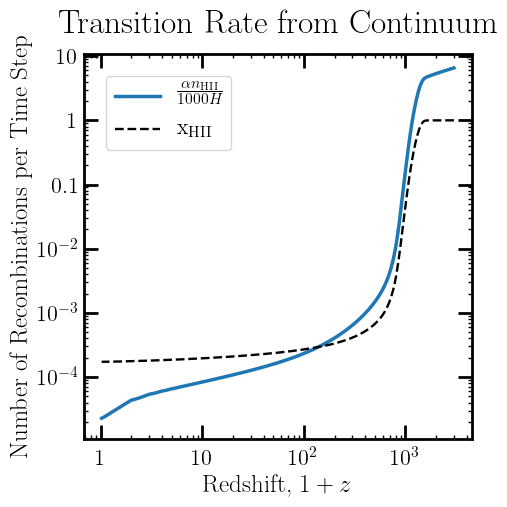

In [44]:
plt.figure(figsize=(5,5))
plt.loglog()
plt.ylim(1.1e-5,11)
plt.plot(rs_list, recomb*.001/phys.hubble(rs_list), label=r'$\frac{\alpha n_{\mathrm{HII}}}{1000 H}$')
# plt.plot(rs_list, tot_rates['1s']*.001/phys.hubble(rs_list), label=r'$1s \to nl$')
# plt.plot(rs_list, tot_rates['2s']*.001/phys.hubble(rs_list), label=r'$1s \to nl$')
plt.plot(rs_list, xHII, linestyle='--', linewidth=1.7, color='k', label=r'x$_{\mathrm{HII}}$')
plt.xlabel(r'Redshift, $1+z$')
plt.ylabel('Number of Recombinations per Time Step')
plt.title('Transition Rate from Continuum')
plt.legend()
# plt.savefig('/Users/gregoryridgway/Dropbox (MIT)/DarkHistory_V2/notes/figs/Recombs.pdf')

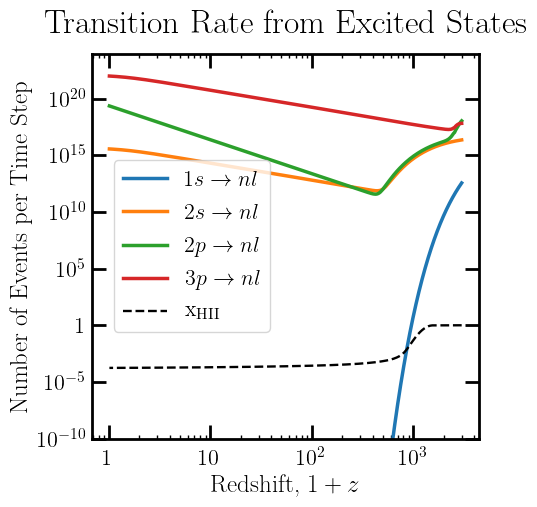

In [45]:
plt.figure(figsize=(5,5))
plt.loglog()
plt.ylim(1e-10,1e24)
# plt.plot(rs_list, recomb*.001/phys.hubble(rs_list), label='Recombination')
plt.plot(rs_list, tot_rates['1s']*.001/phys.hubble(rs_list), label=r'$1s \to nl$')
plt.plot(rs_list, tot_rates['2s']*.001/phys.hubble(rs_list), label=r'$2s \to nl$')
plt.plot(rs_list, tot_rates['2p']*.001/phys.hubble(rs_list), label=r'$2p \to nl$')
plt.plot(rs_list, tot_rates['3p']*.001/phys.hubble(rs_list), label=r'$3p \to nl$')
plt.plot(rs_list, xHII, linestyle='--', linewidth=1.7, color='k', label=r'x$_{\mathrm{HII}}$')
plt.xlabel(r'Redshift, $1+z$')
plt.ylabel('Number of Events per Time Step')
plt.title('Transition Rate from Excited States')
plt.legend()
# plt.savefig('/Users/gregoryridgway/Dropbox (MIT)/DarkHistory_V2/notes/figs/Transitions.pdf')

## Greg's extra stuff???

In [30]:
def get_transition(init, BB, iterations=1):
    spectroscopic = ['s', 'p', 'd', 'f']+[str(k) for k in np.arange(4,BB['up'].shape[0])]
    spec_dict = {spec: i for i,spec in enumerate(spectroscopic)}
    
    final_chain=[]
    final_probs=[]
    
    prev_chains = np.array([[init]])
    prev_probs  = [1.0]
    count=0
    while count<iterations:
        chains=[]
        probs=[]
        for prob,chain in zip(prev_probs,prev_chains):
            n = int(chain[-1][0])
            l = spec_dict[chain[-1][1]]
            
            tot_rate = np.sum(BB['dn'][n,:,l]+BB['up'][n,:,l])
            link_up = [k for k,x in enumerate(prob*BB['up'][n,:,l]/tot_rate>1e-3) if x]
            link_dn = [k for k,x in enumerate(prob*BB['dn'][n,:,l]/tot_rate>1e-3) if x]
#             print(sum(link_up), sum(link_dn))

            chains.append(np.array(
                [np.append(chain,str(link)+spectroscopic[l+1]) for link in link_up]+[
                np.append(chain,str(link)+spectroscopic[max(l-1,0)]) for link in link_dn]
            ))

            probs.append(np.array(
                [prob*BB['up'][n,k,l]/tot_rate for k in link_up]+[
                 prob*BB['dn'][n,k,l]/tot_rate for k in link_dn]
            ))
        
        chains = np.concatenate(chains)
        probs = np.concatenate(probs)
        
        mask = (chains[:,-1]=='1s')
        if sum(mask) != 0:
            final_chain.append(chains[mask])
            final_probs.append(probs[mask])
            
            chains = chains[~mask]
            probs  = probs[~mask]
        
        if count>0:
            mask2 = (chains[:,-3] == chains[:,-1])
            print(mask2)
            if sum(mask2) != 0:
                final_chain.append(chains[mask2])
                final_probs.append(probs[mask2])
                
            chains = chains[~mask2]
            probs  = probs[~mask2]

        prev_chains = chains.copy()
        prev_probs = probs.copy()
            
        
        count+=1
        
    
    return prev_chains, prev_probs, final_chain, final_probs

In [780]:
chains, probs, final_chain, final_probs = get_transition('2p', BB, 2)
chains, probs, final_chain, final_probs

[False  True  True  True]


(array([['2p', '3d', '4f']], dtype='<U2'),
 array([0.00265437]),
 [array([['2p', '1s']], dtype='<U2'), array([['2p', '3d', '2p'],
         ['2p', '4d', '2p'],
         ['2p', '3s', '2p']], dtype='<U2')],
 [array([0.01316213]), array([0.96211057, 0.00205375, 0.01857682])])

In [31]:
def get_transition(init, BB, iterations=1):
    spectroscopic = ['s', 'p', 'd', 'f']+[str(k) for k in np.arange(4,BB['up'].shape[0])]
    spec_dict = {spec: i for i,spec in enumerate(spectroscopic)}
    
    prev_chains = np.array([[init]])
    prev_probs  = [1.0]
    count=0
    while count<iterations:
        chains=[]
        probs=[]
        for prob,chain in zip(prev_probs,prev_chains):
            n = int(chain[-1][0])
            l = spec_dict[chain[-1][1]]
            
            tot_rate = np.sum(BB['dn'][n,:,l]+BB['up'][n,:,l])
            link_up = [k for k,x in enumerate(prob*BB['up'][n,:,l]/tot_rate>1e-3) if x]
            link_dn = [k for k,x in enumerate(prob*BB['dn'][n,:,l]/tot_rate>1e-3) if x]

            chains.append(np.array(
                [np.append(chain,str(link)+spectroscopic[l+1]) for link in link_up]+[
                np.append(chain,str(link)+spectroscopic[max(l-1,0)]) for link in link_dn]
            ))

            probs.append(np.array(
                [prob*BB['up'][n,k,l]/tot_rate for k in link_up]+[
                 prob*BB['dn'][n,k,l]/tot_rate for k in link_dn]
            ))

        prev_chains = np.concatenate(chains)
        prev_probs = np.concatenate(probs)
        count+=1
        
    
    return prev_chains, prev_probs

In [465]:
get_transition('2p', BB, 2)

(array([['2p', '1s', '2p']], dtype='<U2'), array([1.]))